**This project was done as part of the course COMP90049 , Introduction to Machine Learning at the University of Melbourne**

**Classifying the Geolocation of Tweets - Mohammed Ahsan Kollathodi**


This jupyter notebook consists of one or more programs that is written in Python with all the code for :


<n>1.model implementation
<n>2.Label Prediction
<n>3.Evaluation

Instructions : 
1. Please run the code sequentially from the beginning . 
2. Install the appropriate packages with latest versions required to run the code. (given in readme.txt file) 





In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

warnings.filterwarnings('ignore');
%matplotlib inline

# Load Data

In [5]:
!ls data/

README.txt         dev_tfidf.csv      test_tfidf.csv     train_tfidf.csv
dev_count.csv      test_count.csv     train_count.csv    vocab.txt
dev_full.csv       test_full.csv      train_full.csv
dev_glove300.csv   test_glove300.csv  train_glove300.csv


In [6]:
train = pd.read_csv('data/train_glove300.csv')
dev = pd.read_csv('data/dev_glove300.csv')
test = pd.read_csv('data/test_glove300.csv')

In [7]:
train.head()

,region,user,tweet
0,NORTHEAST,USER_6197f95d,0.16529499739408493 0.15692149847745895 0.1295...
1,NORTHEAST,USER_6197f95d,0.12859000265598297 0.2504599988460541 -0.5546...
2,NORTHEAST,USER_6197f95d,-0.20041219741106034 0.3086455903947353 -0.041...
3,NORTHEAST,USER_6197f95d,-0.14732199907302856 0.3644040012732148 0.1265...
4,NORTHEAST,USER_6197f95d,0.07860666265090306 -0.19449666266640028 -0.25...


In [8]:
test.head()

,region,user,tweet
0,?,USER_e34edf78,0.07743729727671426 -0.03284658798400093 -0.09...
1,?,USER_e34edf78,-0.0972022470086813 -0.17957499623298645 0.102...
2,?,USER_e34edf78,-0.013611395657062531 -0.08937279544770718 -0....
3,?,USER_e34edf78,0.0958620011806488 -0.17400999069213868 0.0420...
4,?,USER_e34edf78,-0.08330000191926956 -0.20895999670028687 -0.0...


# Cleaning Up Training Data

In [9]:
train.region.value_counts()

NORTHEAST    52582
SOUTH        49901
WEST         16228
MIDWEST      15084
Name: region, dtype: int64

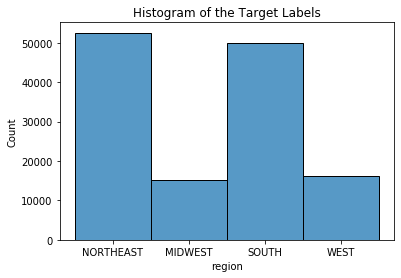

In [10]:
sns.histplot(train.region).set_title('Histogram of the Target Labels');

It looks like there is a big class imbalance between tweets made in the Northeast and South regions and those made in the Midwest and West regions. 

In [11]:
train.describe()

,region,user,tweet
count,133795,133795,133795
unique,4,3400,114875
top,NORTHEAST,USER_6b07169e,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
freq,52582,242,1442


In [12]:
type(train.tweet.iloc[0])

str

1442 don't have any useful information in the glove vector because the entire vector is full of zeros, we will remove those datapoints.

There is enough remaining data to train a robust model.

In [13]:
drop_df = train[train.tweet == '0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0']

In [14]:
drop_df.head()

,region,user,tweet
267,SOUTH,USER_cd29704a,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
278,SOUTH,USER_cd29704a,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
279,SOUTH,USER_cd29704a,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
281,SOUTH,USER_cd29704a,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
388,SOUTH,USER_afa7ebf8,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [15]:
drop_df.region.value_counts()

NORTHEAST    700
SOUTH        479
WEST         137
MIDWEST      126
Name: region, dtype: int64

At a glance, it looks like the tweets that are dropping share a similar distribution of target labels as the training dataset on the whole. 

Removing them won't skew the target label class distribution. 

In [16]:
train_preprocessed = train.drop(drop_df.index)
print(train.shape, train_preprocessed.shape)
train_preprocessed.head()

(133795, 3) (132353, 3)


,region,user,tweet
0,NORTHEAST,USER_6197f95d,0.16529499739408493 0.15692149847745895 0.1295...
1,NORTHEAST,USER_6197f95d,0.12859000265598297 0.2504599988460541 -0.5546...
2,NORTHEAST,USER_6197f95d,-0.20041219741106034 0.3086455903947353 -0.041...
3,NORTHEAST,USER_6197f95d,-0.14732199907302856 0.3644040012732148 0.1265...
4,NORTHEAST,USER_6197f95d,0.07860666265090306 -0.19449666266640028 -0.25...


In [17]:
train_preprocessed.describe()

,region,user,tweet
count,132353,132353,132353
unique,4,3400,114874
top,NORTHEAST,USER_6b07169e,0.23725999891757965 -0.4605099856853485 0.0755...
freq,51882,232,1233


Something to note is that some tweets or their glove vector representations are duplicated across the dataset. 

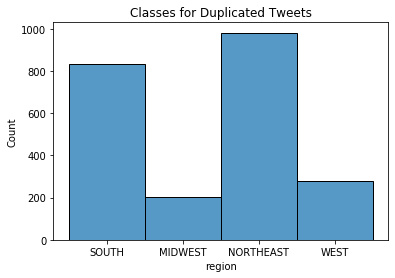

In [18]:
sns.histplot(train_preprocessed[train_preprocessed.duplicated()].region).set_title('Classes for Duplicated Tweets');

Above is the distribution of the target class labels of rows with duplicate tweets. There is no need to reduce the number of training datapoints for the Western and Midwestern Regions, so a good idea would be to drop the duplicates of those rows in the Northeastern and Southern Region. This slightly balances the class imbalance and remove those duplicates.

In [19]:
train_preprocessed = train_preprocessed[~((train_preprocessed.region.isin(['NORTHEAST','SOUTH']) &\
                                        (train_preprocessed.duplicated())))]

In [20]:
print(train.shape, train_preprocessed.shape)

(133795, 3) (130540, 3)


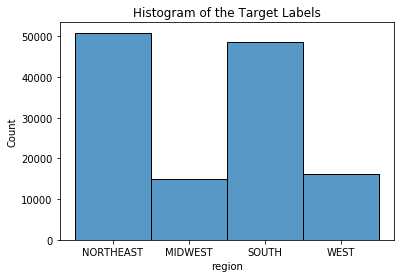

In [21]:
sns.histplot(train_preprocessed.region).set_title('Histogram of the Target Labels');

Below we will create the numpy 300 dimensional feature array. 

In [22]:
train_preprocessed['feature_array'] =train_preprocessed.tweet.map(lambda x: np.array([float(i) for i in x.split(' ')]))

In [23]:
train_preprocessed.feature_array.map(lambda x: x.size).value_counts()

300    130540
Name: feature_array, dtype: int64

In [24]:
train_preprocessed.isnull().sum()

region           0
user             0
tweet            0
feature_array    0
dtype: int64

Next step is to shuffle the dataframe to make sure that there is no order to the target class labels and/or that they are not clumped together. 

In [25]:
train_preprocessed = train_preprocessed.sample(frac = 1)

# Preprocessing Dev Data

In [26]:
dev.head()

,region,user,tweet
0,NORTHEAST,USER_e96c1548,-0.028180110371775098 -0.03476144280284643 -0....
1,NORTHEAST,USER_e96c1548,-0.16395900088051954 0.04037083126604557 -0.20...
2,NORTHEAST,USER_e96c1548,-0.07742499560117722 -0.09208500385284424 -0.4...
3,NORTHEAST,USER_e96c1548,-0.31334999203681946 -0.3493500053882599 -0.18...
4,NORTHEAST,USER_e96c1548,0.19321999847888946 0.07786999940872193 -0.039...


In [27]:
zeros_df = dev[dev.tweet == '0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0']

In [28]:
zeros_df.head()

,region,user,tweet
63,SOUTH,USER_019176d1,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
124,SOUTH,USER_023393a1,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
164,NORTHEAST,USER_4ec79b73,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
175,NORTHEAST,USER_4ec79b73,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
178,NORTHEAST,USER_4ec79b73,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [29]:
zeros_df.region.value_counts()

NORTHEAST    50
SOUTH        28
MIDWEST      13
WEST          9
Name: region, dtype: int64

There aren't too many datapoints in the dev set that have empty glove vectors. 

In [30]:
dev['feature_array'] =dev.tweet.map(lambda x: np.array([float(i) for i in x.split(' ')]))

# One Rule Baseline

A function to use as a baseline model that returns the label of the class that appears most often in the training data.

In [31]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [32]:
def get_report(model):
    print('***** Training Set Performance ******')
    train_pred = model.predict(X)
    train_actual = y
    
    print(classification_report(train_actual,train_pred))
    print('***** Training Confusion Matrix ******')
    print(confusion_matrix(train_actual,train_pred))
    
    print('\n***** Dev Set Performance ******')
    dev_pred = model.predict(list(dev.feature_array))
    dev_actual = dev.region
    
    print(classification_report(dev_actual,dev_pred))
    print('***** Dev Confusion Matrix ******')
    print(confusion_matrix(dev_actual,dev_pred))

In [33]:
class OneRuleBaseline:
    
    prediction = "Fit hasn't been called."
    
    def fit (self, X, y):
        self.prediction = y.value_counts().index[0]
    
    def predict(self, X):
        return [self.prediction]*len(X)
                      

X = list(train_preprocessed.feature_array)
y = train_preprocessed.region

baseline = OneRuleBaseline()
baseline.fit(X,y)
baseline.predict(X)

['NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORTHEAST',
 'NORT

In [34]:
get_report(baseline)

***** Training Set Performance ******
              precision    recall  f1-score   support

     MIDWEST       0.00      0.00      0.00     14958
   NORTHEAST       0.39      1.00      0.56     50901
       SOUTH       0.00      0.00      0.00     48590
        WEST       0.00      0.00      0.00     16091

    accuracy                           0.39    130540
   macro avg       0.10      0.25      0.14    130540
weighted avg       0.15      0.39      0.22    130540

***** Training Confusion Matrix ******
[[    0 14958     0     0]
 [    0 50901     0     0]
 [    0 48590     0     0]
 [    0 16091     0     0]]

***** Dev Set Performance ******
              precision    recall  f1-score   support

     MIDWEST       0.00      0.00      0.00      1484
   NORTHEAST       0.37      1.00      0.54      4295
       SOUTH       0.00      0.00      0.00      4266
        WEST       0.00      0.00      0.00      1430

    accuracy                           0.37     11475
   macro avg       

The baseline accuracy for training dataset is 39% and the baseline accuracy for the dev dataset is 37% accuracy. 

The baseline macro avg f1 score is 14% for the training and 14% for the dev.

# Training Logistic Regression

Naive Bayes is based on applying Bayes' theorem with strong independence assumptions between the features. Since my training features is the averaged word vector for the tweet, each variable is not independent from the rest.

Logisitic Regression handles feature variables that are not fully independent better, and it allows for negative feature values, so  using it as the first simple model would be a better idea. It unfortunately handles larger data less/quickly than Naive Bayes does ( takes longer to converge to it's best performance) so we will likely have to increase the maximum training interations parameter in sklearn. 

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix

In [36]:
X = list(train_preprocessed.feature_array)
y = train_preprocessed.region

lr_baseline1 = LogisticRegression(max_iter = 1000)
lr_baseline1.fit(X, y)

LogisticRegression(max_iter=1000)

In [37]:
def get_report(model):
    print('***** Training Set Performance ******')
    train_pred = model.predict(X)
    train_actual = y
    
    print(classification_report(train_actual,train_pred))
    
    plot_confusion_matrix(model,X,y)
    plt.show() 
    
    print('\n***** Dev Set Performance ******')
    dev_pred = model.predict(list(dev.feature_array))
    dev_actual = dev.region
    
    print(classification_report(dev_actual,dev_pred))
    
    plot_confusion_matrix(model,list(dev.feature_array),dev_actual)
    plt.show() 

***** Training Set Performance ******
              precision    recall  f1-score   support

     MIDWEST       0.18      0.00      0.00     14958
   NORTHEAST       0.48      0.60      0.53     50901
       SOUTH       0.43      0.58      0.49     48590
        WEST       0.34      0.00      0.01     16091

    accuracy                           0.45    130540
   macro avg       0.36      0.30      0.26    130540
weighted avg       0.41      0.45      0.39    130540



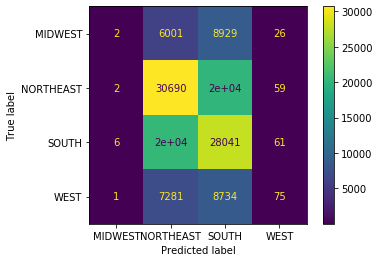


***** Dev Set Performance ******
              precision    recall  f1-score   support

     MIDWEST       0.00      0.00      0.00      1484
   NORTHEAST       0.46      0.60      0.52      4295
       SOUTH       0.42      0.57      0.48      4266
        WEST       0.24      0.00      0.01      1430

    accuracy                           0.44     11475
   macro avg       0.28      0.29      0.25     11475
weighted avg       0.36      0.44      0.37     11475



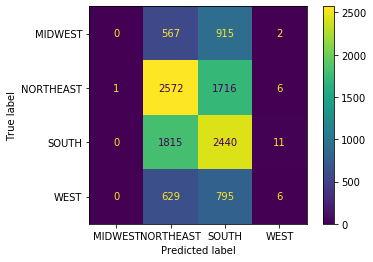

In [38]:
get_report(lr_baseline1)

Our LR model only gets a 45% accuracy on our training set and 44% accuracy on our dev set. 

It barely captures any of the datapoints with MIDWEST & WEST as target labels. Those are the target labels that aren't well represented in the training data. 

# Upsample Minority Class to Improve Class Imbalance

In [39]:
from sklearn.utils import resample

In [40]:
train_preprocessed.region.value_counts()

NORTHEAST    50901
SOUTH        48590
WEST         16091
MIDWEST      14958
Name: region, dtype: int64

In [41]:
train_min = train_preprocessed[train_preprocessed.region.isin(['MIDWEST','WEST'])]
train_maj = train_preprocessed[train_preprocessed.region.isin(['NORTHEAST','SOUTH'])]

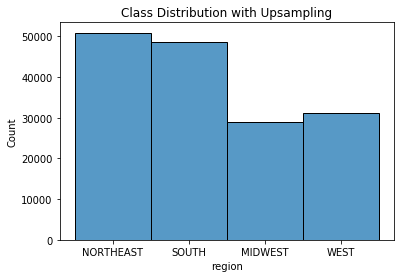

In [42]:
train_min_upsampled = resample(train_min, replace=True, n_samples=60000, random_state=1)
train_upsampled = pd.concat([train_maj, train_min_upsampled])
 
sns.histplot(train_upsampled.region).set_title('Class Distribution with Upsampling');

# Retrain LR to See if Upsampling Helped

***** Training Set Performance ******
              precision    recall  f1-score   support

     MIDWEST       0.31      0.02      0.04     28948
   NORTHEAST       0.40      0.59      0.48     50901
       SOUTH       0.35      0.55      0.42     48590
        WEST       0.34      0.07      0.11     31052

    accuracy                           0.37    159491
   macro avg       0.35      0.31      0.26    159491
weighted avg       0.36      0.37      0.31    159491



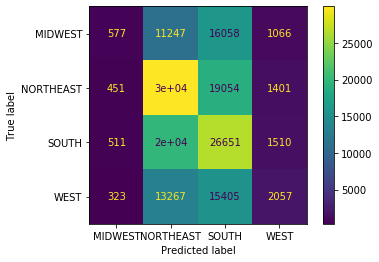


***** Dev Set Performance ******
              precision    recall  f1-score   support

     MIDWEST       0.05      0.00      0.01      1484
   NORTHEAST       0.46      0.58      0.52      4295
       SOUTH       0.42      0.54      0.47      4266
        WEST       0.17      0.06      0.08      1430

    accuracy                           0.43     11475
   macro avg       0.28      0.30      0.27     11475
weighted avg       0.36      0.43      0.38     11475



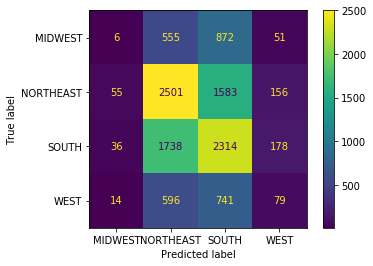

In [43]:
X = list(train_upsampled.feature_array)
y = train_upsampled.region

lr_baseline2 = LogisticRegression(max_iter = 1000)
lr_baseline2.fit(X, y)
get_report(lr_baseline2)

Upsampling helped a bit but not nearly enough. The majority of the datapoints are still getting a prediction of Northeast or South.

# Downsampling Majority Class

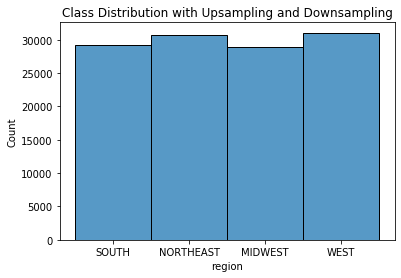

In [44]:
train_maj_downsampled = resample(train_maj, replace=False, n_samples=60000, random_state = 1)
train_upANDdownsampled = pd.concat([train_maj_downsampled, train_min_upsampled])

sns.histplot(train_upANDdownsampled.region).set_title('Class Distribution with Upsampling and Downsampling');

# Retrain LR to See if Downsampling Helped

***** Training Set Performance ******
              precision    recall  f1-score   support

     MIDWEST       0.31      0.30      0.30     28948
   NORTHEAST       0.37      0.46      0.41     30738
       SOUTH       0.32      0.21      0.25     29262
        WEST       0.33      0.38      0.35     31052

    accuracy                           0.34    120000
   macro avg       0.33      0.33      0.33    120000
weighted avg       0.33      0.34      0.33    120000



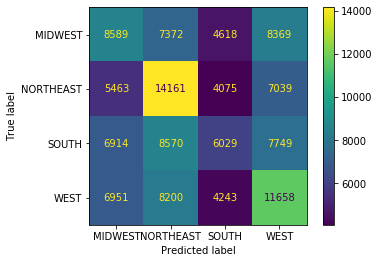


***** Dev Set Performance ******
              precision    recall  f1-score   support

     MIDWEST       0.16      0.26      0.20      1484
   NORTHEAST       0.49      0.45      0.47      4295
       SOUTH       0.43      0.18      0.26      4266
        WEST       0.15      0.33      0.20      1430

    accuracy                           0.31     11475
   macro avg       0.30      0.31      0.28     11475
weighted avg       0.38      0.31      0.32     11475



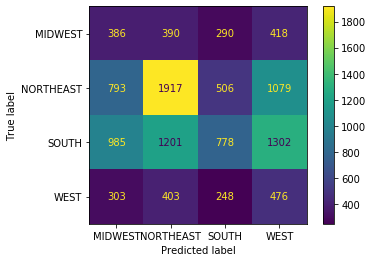

In [45]:
X = list(train_upANDdownsampled.feature_array)
y = train_upANDdownsampled.region

lr_baseline3 = LogisticRegression(max_iter = 1000)
lr_baseline3.fit(X, y)
get_report(lr_baseline3)

Upsampling & Downsampling reduced the 'Accuracy' of our overall LR model, but made the recall across our 4 target classes more event -- giving us a higher macro averaged f1 score. 

# OVR LR

The confusion matrices show that a lot of the class labels are not getting correctly predicted. So we would have to see if running a One vs. Rest LR helps reduce the class bias.

***** Training Set Performance ******
              precision    recall  f1-score   support

     MIDWEST       0.31      0.29      0.30     28948
   NORTHEAST       0.37      0.47      0.41     30738
       SOUTH       0.32      0.20      0.24     29262
        WEST       0.33      0.38      0.35     31052

    accuracy                           0.34    120000
   macro avg       0.33      0.33      0.33    120000
weighted avg       0.33      0.34      0.33    120000



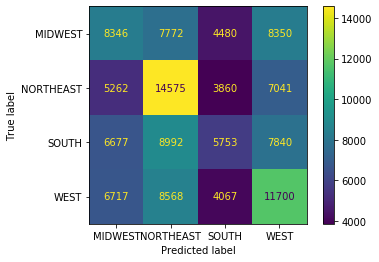


***** Dev Set Performance ******
              precision    recall  f1-score   support

     MIDWEST       0.16      0.25      0.19      1484
   NORTHEAST       0.49      0.46      0.47      4295
       SOUTH       0.43      0.18      0.25      4266
        WEST       0.14      0.33      0.20      1430

    accuracy                           0.31     11475
   macro avg       0.30      0.31      0.28     11475
weighted avg       0.38      0.31      0.32     11475



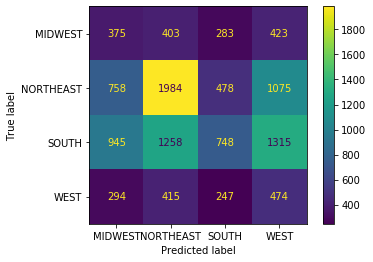

In [46]:
X = list(train_upANDdownsampled.feature_array)
y = train_upANDdownsampled.region

lr_baseline4 = LogisticRegression(max_iter = 1000, multi_class='ovr')
lr_baseline4.fit(X, y)
get_report(lr_baseline4)

# Comparisons of LR

In [47]:
from sklearn.metrics import precision_recall_fscore_support

In [48]:
def get_dev_plot(models, metric = 'f1'):
    print('\n***** Dev Set Performance ******')
    print(metric)
    dev_actual = dev.region
    
    metrics = []
    x = []
    for i, model in enumerate(models):
        dev_pred = model.predict(list(dev.feature_array))
        metrics.append(precision_recall_fscore_support(dev_actual,dev_pred, average = 'macro'))
        x.append('v'+str(i))
        
    if metric == 'precision':
        y = [m[0] for m in metrics]
        plt.bar(x,y)
        plt.show() 
        
    if metric == 'recall':
        y = [m[1] for m in metrics]
        plt.bar(x,y)
        plt.show() 
        
    if metric == 'f1':
        y = [m[2] for m in metrics]
        plt.bar(x,y)
        plt.show()   
        



***** Dev Set Performance ******
precision


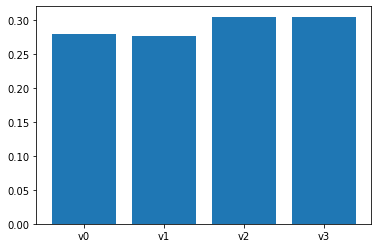

In [49]:
get_dev_plot([lr_baseline1, lr_baseline2, lr_baseline3, lr_baseline4], metric = 'precision')


***** Dev Set Performance ******
recall


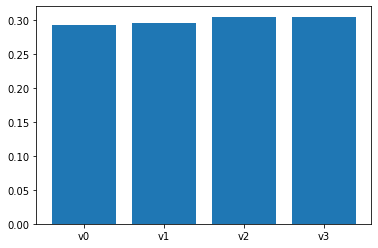

In [50]:
get_dev_plot([lr_baseline1, lr_baseline2, lr_baseline3, lr_baseline4], metric = 'recall')


***** Dev Set Performance ******
f1


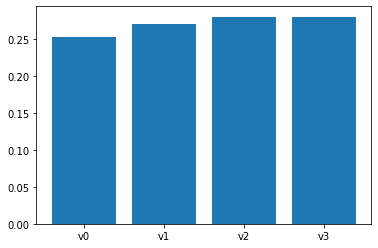

In [51]:
get_dev_plot([lr_baseline1, lr_baseline2, lr_baseline3, lr_baseline4], metric = 'f1')

# KNN

KNN takes a very long time to label a datapoint. 

In [52]:
from sklearn.neighbors import KNeighborsClassifier

In [53]:
def get_report(model, show_more = True, n = 1000):
    if show_more == True: 
        
        print('***** Training Set Performance ******')
        train_pred = model.predict(X)
        train_actual = y

        print(classification_report(train_actual,train_pred))

        plot_confusion_matrix(model,X,y)
        plt.show() 
    
    print('\n***** Dev Set Performance ******')
    dev_pred = model.predict(list(dev.feature_array)[:n])
    dev_actual = list(dev.region)[:n]
    
    print(classification_report(dev_actual,dev_pred))
    
    if show_more == True: 
        plot_confusion_matrix(model,list(dev.feature_array),dev_actual)
        plt.show() 

In [54]:
X = list(train_upANDdownsampled.feature_array)
y = train_upANDdownsampled.region

knn_1 = KNeighborsClassifier(n_neighbors=3)
knn_1.fit(X, y)

KNeighborsClassifier(n_neighbors=3)

In [55]:
get_report(knn_1, show_more = False)


***** Dev Set Performance ******
              precision    recall  f1-score   support

     MIDWEST       0.16      0.28      0.20       151
   NORTHEAST       0.59      0.31      0.41       572
       SOUTH       0.18      0.27      0.21       173
        WEST       0.10      0.17      0.13       104

    accuracy                           0.28      1000
   macro avg       0.26      0.26      0.24      1000
weighted avg       0.40      0.28      0.31      1000



In [56]:
X = list(train_upANDdownsampled.feature_array)
y = train_upANDdownsampled.region

knn_2 = KNeighborsClassifier(n_neighbors=5)
knn_2.fit(X, y)

KNeighborsClassifier()

In [57]:
get_report(knn_2, show_more = False)


***** Dev Set Performance ******
              precision    recall  f1-score   support

     MIDWEST       0.16      0.32      0.21       151
   NORTHEAST       0.61      0.28      0.38       572
       SOUTH       0.18      0.24      0.21       173
        WEST       0.09      0.16      0.12       104

    accuracy                           0.27      1000
   macro avg       0.26      0.25      0.23      1000
weighted avg       0.41      0.27      0.30      1000



In [265]:
X = list(train_upANDdownsampled.feature_array)
y = train_upANDdownsampled.region

knn_3 = KNeighborsClassifier(n_neighbors=10)
knn_3.fit(X, y)

KNeighborsClassifier(n_neighbors=10)

In [266]:
get_report(knn_3, show_more = False)


***** Dev Set Performance ******
              precision    recall  f1-score   support

     MIDWEST       0.15      0.34      0.21       151
   NORTHEAST       0.61      0.24      0.34       572
       SOUTH       0.16      0.19      0.18       173
        WEST       0.09      0.21      0.13       104

    accuracy                           0.24      1000
   macro avg       0.25      0.25      0.22      1000
weighted avg       0.41      0.24      0.27      1000



# Random Forest

In [267]:
def get_report(model):
    print('***** Training Set Performance ******')
    train_pred = model.predict(X)
    train_actual = y
    
    print(classification_report(train_actual,train_pred))
    
    plot_confusion_matrix(model,X,y)
    plt.show() 
    
    print('\n***** Dev Set Performance ******')
    dev_pred = model.predict(list(dev.feature_array))
    dev_actual = dev.region
    
    print(classification_report(dev_actual,dev_pred))
    
    plot_confusion_matrix(model,list(dev.feature_array),dev_actual)
    plt.show() 

In [268]:
from sklearn.ensemble import RandomForestClassifier

***** Training Set Performance ******
              precision    recall  f1-score   support

     MIDWEST       0.95      0.94      0.94     28891
   NORTHEAST       0.95      0.92      0.94     30762
       SOUTH       0.97      0.91      0.94     29238
        WEST       0.88      0.97      0.92     31109

    accuracy                           0.94    120000
   macro avg       0.94      0.94      0.94    120000
weighted avg       0.94      0.94      0.94    120000



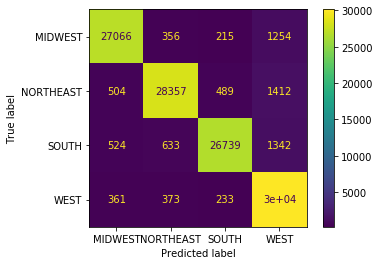


***** Dev Set Performance ******
              precision    recall  f1-score   support

     MIDWEST       0.15      0.04      0.07      1484
   NORTHEAST       0.44      0.54      0.49      4295
       SOUTH       0.41      0.46      0.43      4266
        WEST       0.15      0.10      0.12      1430

    accuracy                           0.39     11475
   macro avg       0.29      0.29      0.28     11475
weighted avg       0.36      0.39      0.37     11475



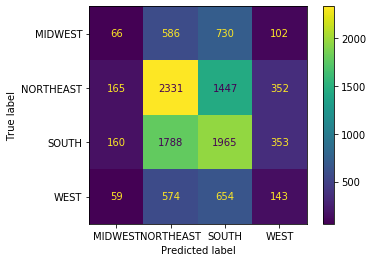

In [269]:
X = list(train_upANDdownsampled.feature_array)
y = train_upANDdownsampled.region

rfc_1 = RandomForestClassifier()
rfc_1.fit(X, y)
get_report(rfc_1)

The first attempt at a Random Forest is performing almost perfectly on the training set, but not so well on the test set. This means that it is overfitting to the training data, or starting to memorize it as opposed to learn generalized rules about it. 

So here we have some of the regularization parameters of the Random Forest.

***** Training Set Performance ******
              precision    recall  f1-score   support

     MIDWEST       0.76      0.83      0.79     28891
   NORTHEAST       0.79      0.70      0.74     30762
       SOUTH       0.76      0.65      0.70     29238
        WEST       0.75      0.86      0.80     31109

    accuracy                           0.76    120000
   macro avg       0.76      0.76      0.76    120000
weighted avg       0.76      0.76      0.76    120000



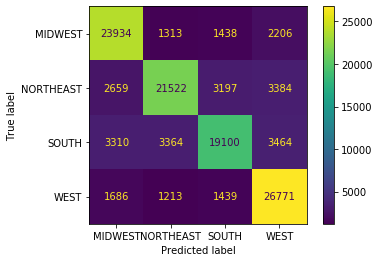


***** Dev Set Performance ******
              precision    recall  f1-score   support

     MIDWEST       0.16      0.22      0.18      1484
   NORTHEAST       0.45      0.41      0.43      4295
       SOUTH       0.40      0.28      0.33      4266
        WEST       0.13      0.23      0.17      1430

    accuracy                           0.31     11475
   macro avg       0.29      0.29      0.28     11475
weighted avg       0.36      0.31      0.33     11475



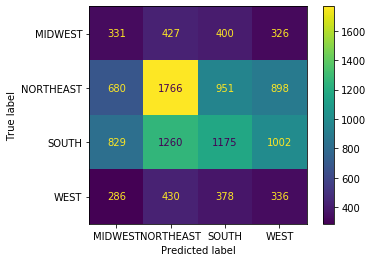

In [270]:
X = list(train_upANDdownsampled.feature_array)
y = train_upANDdownsampled.region

rfc_2 = RandomForestClassifier(n_estimators = 10, max_depth = 15, n_jobs = -1)
rfc_2.fit(X, y)
get_report(rfc_2)

It looks like it's still overfitting, maybe we can run a small Grid Search to find the best parameters. 

In [271]:
from sklearn.model_selection import GridSearchCV

X = list(train_upANDdownsampled.feature_array)
y = train_upANDdownsampled.region

parameters = {'n_estimators': [7, 10, 15],
#                'criterion': ['gini','entropy'],
               'max_depth': [10, 15, 20, 25],
#                'min_samples_split': [2, 5, 10],
#                'min_samples_leaf': [1, 2, 4],
#                'min_impurity_decrease': [.01,.05,.1],
#                'ccp_alpha': [.01,.05,.1]
             }

In [272]:
rfc = RandomForestClassifier()
rfc_3 = GridSearchCV(rfc, parameters, n_jobs = -1, cv = 3, verbose=True, scoring = 'f1_macro')
rfc_3.fit(X,y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20, 25],
                         'n_estimators': [7, 10, 15]},
             scoring='f1_macro', verbose=True)

In [273]:
rfc_3.best_params_

{'max_depth': 25, 'n_estimators': 15}

***** Training Set Performance ******
              precision    recall  f1-score   support

     MIDWEST       0.95      0.94      0.94     28891
   NORTHEAST       0.95      0.92      0.93     30762
       SOUTH       0.96      0.91      0.94     29238
        WEST       0.88      0.97      0.92     31109

    accuracy                           0.93    120000
   macro avg       0.94      0.93      0.93    120000
weighted avg       0.93      0.93      0.93    120000



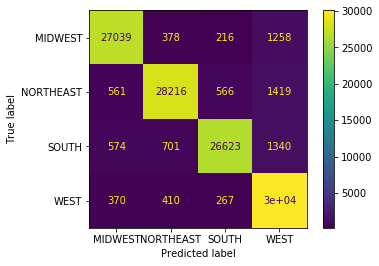


***** Dev Set Performance ******
              precision    recall  f1-score   support

     MIDWEST       0.15      0.12      0.13      1484
   NORTHEAST       0.42      0.45      0.43      4295
       SOUTH       0.39      0.37      0.38      4266
        WEST       0.13      0.16      0.14      1430

    accuracy                           0.34     11475
   macro avg       0.27      0.27      0.27     11475
weighted avg       0.34      0.34      0.34     11475



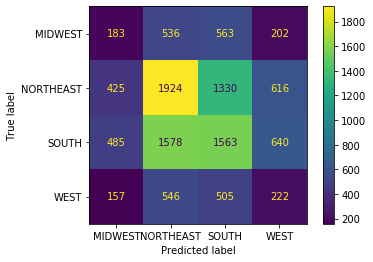

In [274]:
get_report(rfc_3)

The grid search took too long to run, so we can minimize the parameters and it ended up overfitting as well. I'm going to play around with some additional combinations myself.

***** Training Set Performance ******
              precision    recall  f1-score   support

     MIDWEST       0.53      0.63      0.57     28891
   NORTHEAST       0.50      0.58      0.54     30762
       SOUTH       0.57      0.28      0.37     29238
        WEST       0.58      0.66      0.62     31109

    accuracy                           0.54    120000
   macro avg       0.54      0.54      0.53    120000
weighted avg       0.54      0.54      0.53    120000



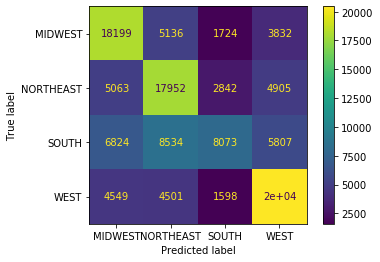


***** Dev Set Performance ******
              precision    recall  f1-score   support

     MIDWEST       0.17      0.30      0.22      1484
   NORTHEAST       0.46      0.47      0.47      4295
       SOUTH       0.41      0.15      0.22      4266
        WEST       0.13      0.26      0.18      1430

    accuracy                           0.31     11475
   macro avg       0.29      0.30      0.27     11475
weighted avg       0.36      0.31      0.31     11475



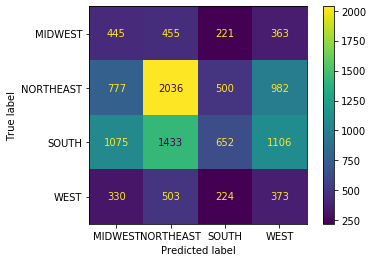

In [275]:
X = list(train_upANDdownsampled.feature_array)
y = train_upANDdownsampled.region

rfc_4 = RandomForestClassifier(n_estimators = 20, max_depth = 10, n_jobs = -1)
rfc_4.fit(X, y)
get_report(rfc_4)

***** Training Set Performance ******
              precision    recall  f1-score   support

     MIDWEST       0.72      0.84      0.77     28891
   NORTHEAST       0.69      0.69      0.69     30762
       SOUTH       0.80      0.57      0.66     29238
        WEST       0.76      0.85      0.80     31109

    accuracy                           0.74    120000
   macro avg       0.74      0.74      0.73    120000
weighted avg       0.74      0.74      0.73    120000



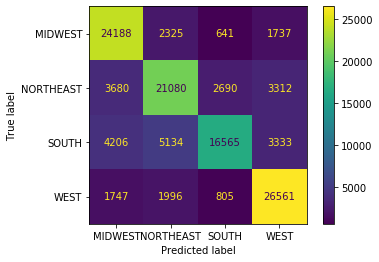


***** Dev Set Performance ******
              precision    recall  f1-score   support

     MIDWEST       0.17      0.26      0.21      1484
   NORTHEAST       0.46      0.52      0.49      4295
       SOUTH       0.40      0.20      0.27      4266
        WEST       0.13      0.22      0.16      1430

    accuracy                           0.33     11475
   macro avg       0.29      0.30      0.28     11475
weighted avg       0.36      0.33      0.33     11475



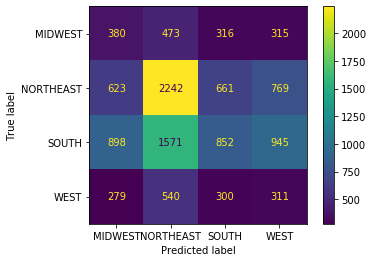

In [276]:
X = list(train_upANDdownsampled.feature_array)
y = train_upANDdownsampled.region

rfc_5 = RandomForestClassifier( max_depth = 12, min_samples_leaf = 2, min_samples_split = 5, n_jobs = -1)
rfc_5.fit(X, y)
get_report(rfc_5)

It seems the Midwest and West regions are getting confused with the NorthEast and South still. So we could do upsampling to see what happens.

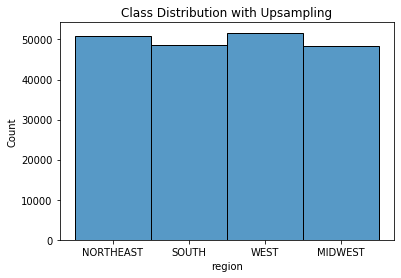

In [277]:
train_min = train_preprocessed[train_preprocessed.region.isin(['MIDWEST','WEST'])]

train_min_upsampled = resample(train_min, replace=True, n_samples=100000, random_state=1)
train_upsampled = pd.concat([train_maj, train_min_upsampled])
 
sns.histplot(train_upsampled.region).set_title('Class Distribution with Upsampling');

***** Training Set Performance ******
              precision    recall  f1-score   support

     MIDWEST       0.68      0.86      0.76     48322
   NORTHEAST       0.65      0.66      0.66     50901
       SOUTH       0.78      0.48      0.59     48590
        WEST       0.76      0.85      0.81     51678

    accuracy                           0.71    199491
   macro avg       0.72      0.71      0.70    199491
weighted avg       0.72      0.71      0.70    199491



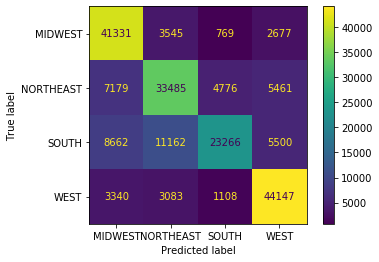


***** Dev Set Performance ******
              precision    recall  f1-score   support

     MIDWEST       0.18      0.28      0.22      1484
   NORTHEAST       0.46      0.53      0.49      4295
       SOUTH       0.41      0.20      0.26      4266
        WEST       0.12      0.18      0.15      1430

    accuracy                           0.33     11475
   macro avg       0.29      0.30      0.28     11475
weighted avg       0.36      0.33      0.33     11475



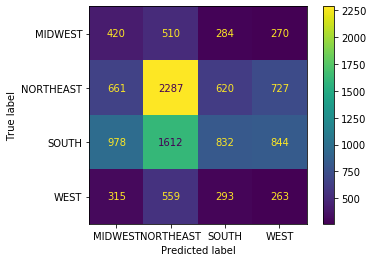

In [278]:
X = list(train_upsampled.feature_array)
y = train_upsampled.region

rfc_6 = RandomForestClassifier( max_depth = 12, n_jobs = -1)
rfc_6.fit(X, y)
get_report(rfc_6)

The Northeastern class also seems to dominate in the predictions.So we will have to downsample those slightly.

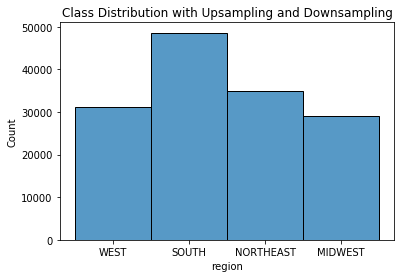

In [58]:
train_south = train_preprocessed[train_preprocessed.region.isin(['SOUTH'])]
train_north = train_preprocessed[train_preprocessed.region.isin(['NORTHEAST'])]

train_maj_downsampled = resample(train_north, replace=False, n_samples=35000, random_state = 1)
train_upANDdownsampled = pd.concat([train_maj_downsampled, train_min_upsampled, train_south])
train_upANDdownsampled = train_upANDdownsampled.sample(frac=1)

sns.histplot(train_upANDdownsampled.region).set_title('Class Distribution with Upsampling and Downsampling');

***** Training Set Performance ******
              precision    recall  f1-score   support

     MIDWEST       0.70      0.90      0.79     48322
   NORTHEAST       0.89      0.33      0.48     35000
       SOUTH       0.68      0.69      0.69     48590
        WEST       0.77      0.89      0.82     51678

    accuracy                           0.73    183590
   macro avg       0.76      0.70      0.69    183590
weighted avg       0.75      0.73      0.71    183590



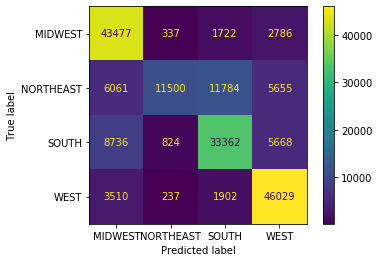


***** Dev Set Performance ******
              precision    recall  f1-score   support

     MIDWEST       0.18      0.31      0.22      1484
   NORTHEAST       0.57      0.14      0.23      4295
       SOUTH       0.38      0.44      0.41      4266
        WEST       0.13      0.26      0.17      1430

    accuracy                           0.29     11475
   macro avg       0.31      0.29      0.26     11475
weighted avg       0.39      0.29      0.29     11475



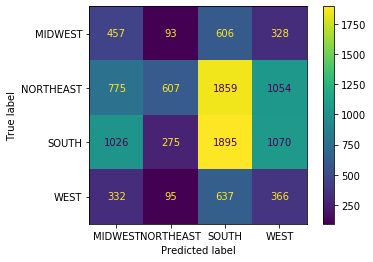

In [280]:
X = list(train_upANDdownsampled.feature_array)
y = train_upANDdownsampled.region

rfc_7 = RandomForestClassifier(max_depth = 12, n_jobs = -1)
rfc_7.fit(X, y)
get_report(rfc_7)

The difference between the training metrics and the developer metrics are very different, In that case we may need to make some additional hyperparameters to make our forest work best. So we can set oob_score = True such that we check the generalization score of the model after fitting. And then we set max_features = None so that it uses all of the features in it's trees training when looking for where to split. This is done because each feature in an averaged word vector and has a lot of latent information in it such that it is a bit undefinable and that ultimately we don't want the model overlooking.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100building tree 5 of 100
building tree 6 of 100

building tree 7 of 100building tree 8 of 100

building tree 9 of 100
building tree 10 of 100building tree 11 of 100
building tree 12 of 100



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.4min


building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100


[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.4min


building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.7min


building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.0min


building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.3min


building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  5.4min


building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  7.9min


building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  9.3min


building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done  88 out of 100 | elapsed: 10.6min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.4min finished


***** Training Set Performance ******


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.0s finished


              precision    recall  f1-score   support

     MIDWEST       0.76      0.91      0.83     48322
   NORTHEAST       0.86      0.41      0.55     35000
       SOUTH       0.72      0.76      0.74     48590
        WEST       0.81      0.91      0.86     51678

    accuracy                           0.77    183590
   macro avg       0.79      0.75      0.74    183590
weighted avg       0.78      0.77      0.76    183590



[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed:    0.9s remaining:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.0s finished


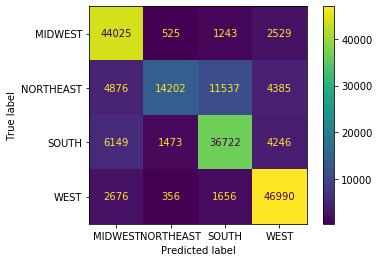


***** Dev Set Performance ******


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


              precision    recall  f1-score   support

     MIDWEST       0.17      0.24      0.20      1484
   NORTHEAST       0.55      0.20      0.30      4295
       SOUTH       0.38      0.47      0.42      4266
        WEST       0.14      0.23      0.17      1430

    accuracy                           0.31     11475
   macro avg       0.31      0.29      0.27     11475
weighted avg       0.39      0.31      0.31     11475



[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


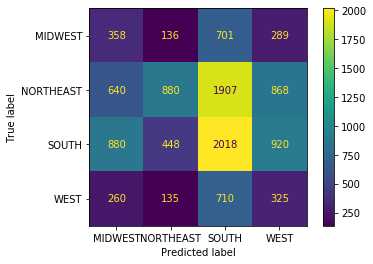

In [281]:
X = list(train_upANDdownsampled.feature_array)
y = train_upANDdownsampled.region

rfc_8 = RandomForestClassifier( max_depth = 12, oob_score=True, max_features = None, 
                                 n_jobs = -1, verbose = 10)
rfc_8.fit(X, y)
get_report(rfc_8)

In [282]:
rfc_8.oob_score_

0.6017865896835339

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10building tree 7 of 10
building tree 8 of 10

building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.0min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished


***** Training Set Performance ******


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.1s finished


              precision    recall  f1-score   support

     MIDWEST       0.54      0.72      0.62     48322
   NORTHEAST       0.60      0.24      0.34     35000
       SOUTH       0.50      0.40      0.45     48590
        WEST       0.57      0.74      0.65     51678

    accuracy                           0.55    183590
   macro avg       0.55      0.52      0.51    183590
weighted avg       0.55      0.55      0.53    183590



[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.1s finished


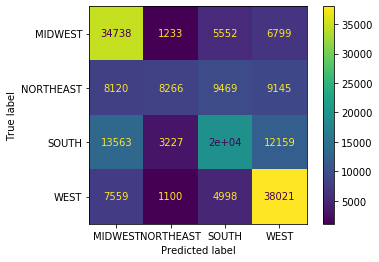


***** Dev Set Performance ******


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


              precision    recall  f1-score   support

     MIDWEST       0.16      0.36      0.22      1484
   NORTHEAST       0.51      0.15      0.23      4295
       SOUTH       0.37      0.29      0.33      4266
        WEST       0.13      0.32      0.18      1430

    accuracy                           0.25     11475
   macro avg       0.29      0.28      0.24     11475
weighted avg       0.37      0.25      0.26     11475



[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


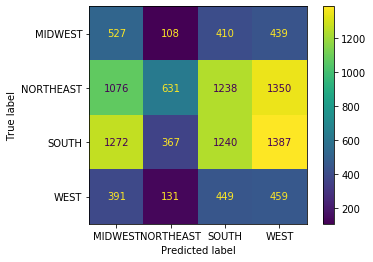

In [283]:
X = list(train_upANDdownsampled.feature_array)
y = train_upANDdownsampled.region

rfc_9 = RandomForestClassifier(n_estimators = 10, max_depth = 10, oob_score=True, max_features = None, 
                              n_jobs = -1, verbose = 2)
rfc_9.fit(X, y)
get_report(rfc_9)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.7min finished


***** Training Set Performance ******


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.2s finished


              precision    recall  f1-score   support

     MIDWEST       0.95      0.94      0.94     48322
   NORTHEAST       0.96      0.89      0.92     35000
       SOUTH       0.96      0.91      0.93     48590
        WEST       0.88      0.97      0.92     51678

    accuracy                           0.93    183590
   macro avg       0.94      0.93      0.93    183590
weighted avg       0.93      0.93      0.93    183590



[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.2s finished


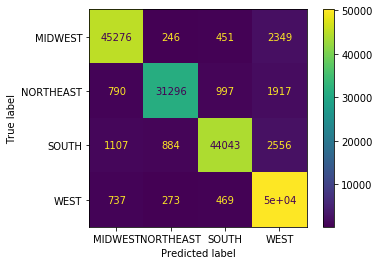


***** Dev Set Performance ******


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


              precision    recall  f1-score   support

     MIDWEST       0.13      0.13      0.13      1484
   NORTHEAST       0.44      0.35      0.39      4295
       SOUTH       0.40      0.48      0.43      4266
        WEST       0.13      0.14      0.14      1430

    accuracy                           0.34     11475
   macro avg       0.28      0.27      0.27     11475
weighted avg       0.34      0.34      0.34     11475



[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


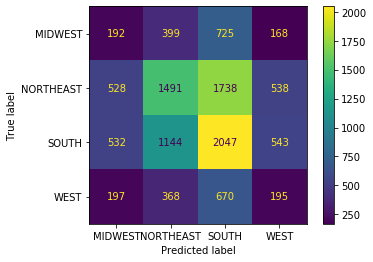

In [284]:
X = list(train_upANDdownsampled.feature_array)
y = train_upANDdownsampled.region

rfc_10 = RandomForestClassifier(n_estimators = 10, oob_score=True, max_features = None, 
                              n_jobs = -1, verbose = 1)
rfc_10.fit(X, y)
get_report(rfc_10)

In [285]:
rfc_10.oob_score_

0.6401710332806798

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500building tree 7 of 500

building tree 8 of 500building tree 9 of 500
building tree 10 of 500building tree 11 of 500
building tree 12 of 500


building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500building tree 18 of 500

building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.3s


building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.1min


building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500


[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  2.6min


building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.8min finished


***** Training Set Performance ******


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    1.6s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    4.0s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    5.9s finished


              precision    recall  f1-score   support

     MIDWEST       0.87      0.94      0.90     48322
   NORTHEAST       0.96      0.59      0.73     35000
       SOUTH       0.81      0.87      0.84     48590
        WEST       0.86      0.96      0.91     51678

    accuracy                           0.86    183590
   macro avg       0.87      0.84      0.84    183590
weighted avg       0.87      0.86      0.85    183590



[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    1.6s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    4.1s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    5.9s finished


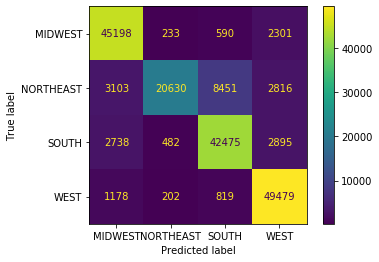


***** Dev Set Performance ******


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.4s finished


              precision    recall  f1-score   support

     MIDWEST       0.19      0.17      0.18      1484
   NORTHEAST       0.55      0.18      0.27      4295
       SOUTH       0.38      0.65      0.48      4266
        WEST       0.13      0.14      0.13      1430

    accuracy                           0.35     11475
   macro avg       0.31      0.28      0.27     11475
weighted avg       0.39      0.35      0.32     11475



[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.4s finished


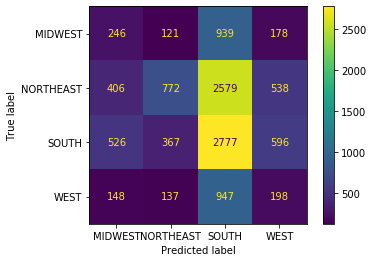

In [286]:
X = list(train_upANDdownsampled.feature_array)
y = train_upANDdownsampled.region

rfc_11 = RandomForestClassifier(n_estimators = 500, max_depth = 15, 
                              n_jobs = -1, verbose = 2)
rfc_11.fit(X, y)
get_report(rfc_11)

In [287]:
rfc_9

RandomForestClassifier(max_depth=10, max_features=None, n_estimators=10,
                       n_jobs=-1, oob_score=True, verbose=2)


***** Dev Set Performance ******
precision


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend

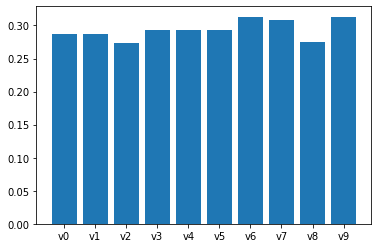


***** Dev Set Performance ******
recall


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend

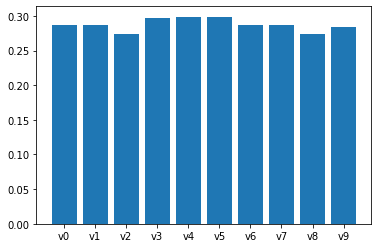


***** Dev Set Performance ******
f1


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend

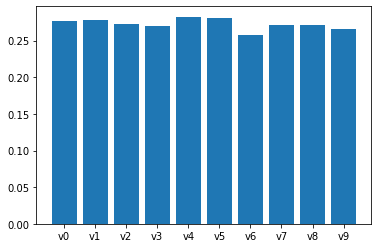

In [288]:
for m in ['precision','recall','f1']:
    get_dev_plot([rfc_1, rfc_2, rfc_3, rfc_4, rfc_5, rfc_6, rfc_7, rfc_8, rfc_10, rfc_11],m);

In [289]:
rfc_5

RandomForestClassifier(max_depth=12, min_samples_leaf=2, min_samples_split=5,
                       n_jobs=-1)

It looks like rfc_5 has the highest f1_macro score for the dev set.This can be used to make predictions on the test set.

# Filling the Test Set

In [290]:
test.head()

,region,user,tweet
0,?,USER_e34edf78,0.07743729727671426 -0.03284658798400093 -0.09...
1,?,USER_e34edf78,-0.0972022470086813 -0.17957499623298645 0.102...
2,?,USER_e34edf78,-0.013611395657062531 -0.08937279544770718 -0....
3,?,USER_e34edf78,0.0958620011806488 -0.17400999069213868 0.0420...
4,?,USER_e34edf78,-0.08330000191926956 -0.20895999670028687 -0.0...


In [291]:
chosen_model = rfc_5
test['feature_array'] = test.tweet.map(lambda x: np.array([float(i) for i in x.split(' ')]))
test_predictions = chosen_model.predict(list(test.feature_array))
test['region'] = test_predictions

In [292]:
test.head()

,region,user,tweet,feature_array
0,MIDWEST,USER_e34edf78,0.07743729727671426 -0.03284658798400093 -0.09...,"[0.07743729727671426, -0.03284658798400093, -0..."
1,SOUTH,USER_e34edf78,-0.0972022470086813 -0.17957499623298645 0.102...,"[-0.0972022470086813, -0.17957499623298645, 0...."
2,NORTHEAST,USER_e34edf78,-0.013611395657062531 -0.08937279544770718 -0....,"[-0.013611395657062531, -0.08937279544770718, ..."
3,MIDWEST,USER_e34edf78,0.0958620011806488 -0.17400999069213868 0.0420...,"[0.0958620011806488, -0.17400999069213868, 0.0..."
4,WEST,USER_e34edf78,-0.08330000191926956 -0.20895999670028687 -0.0...,"[-0.08330000191926956, -0.20895999670028687, -..."


In [293]:
x = test.to_csv('test_glove300_with_predictions.csv')

In [ ]:
# import csv 
# with open ('test_glove300_with_predictions.csv','') as file: 
    # writer = csv.writer(file)
